In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nbody import Particles, NBodySimulator
from nbody import load_files, save_movie
from numba import jit, njit, prange,set_num_threads, config
import os

In [49]:
# Set the number of threads to use for numba
nthreads = 8
set_num_threads(nthreads)
# initial conditions
np.random.seed(0) #fix random
N = 1000
pts = Particles(N)
pts.r = np.random.randn(N,3)
pts.v = np.random.randn(N,3)
pts.a = np.random.randn(N,3)
pts.m = np.ones((N, 1))* 20/N
dt = 0.01
freq = int(0.1/dt)

simulation = NBodySimulator(particles=pts)
simulation.setup(G=1,
                 rsoft=0.01,
                 method='RK4', 
                 io_freq=freq,
                 io_screen=False,
                 visualization=False, 
                 io_header="nbody_video")


In [36]:
accs = simulation._calculate_a(N, pts.m, pts.r)

In [20]:
pts = simulation._advance_particles_RK4(dt, pts)

In [38]:
N = pts.N
ms = pts.m

# k1
rs = pts.r
vs = pts.v
accs = simulation._calculate_a(N, ms, rs)

# k2
rs2 = rs + 0.5 * dt * vs
vs2 = vs + 0.5 * dt * accs
#accs2 = simulation._calculate_a(N, ms, rs2)

In [37]:
%timeit simulation.evolve(dt=0.02, tf=0.2)

91.3 ms ± 3.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
fns = load_files('nbody')
au = 1
save_movie(fns, lengthscale=2*au,filename='nbody.mp4', fps=10)

In [ ]:
print(pts.a[0,0])
print(type(pts.a[0,0]))

In [ ]:
au = 1.496e11
save_movie(fns, lengthscale=2*au,filename='nbody.mp4', fps=10)

In [ ]:
N=5
x = np.zeros((N,3))
x[:,0]=np.arange(N)
acc = np.zeros_like(x)
G=1
rsoft=0
m = np.ones(N)[:,np.newaxis]
m[-3:]=2
#print(m.T)
# distance and direction
# masses: (N,1) matrix

for i in prange(N-1):
    R=np.zeros((N-i-1,3))
    for j in prange(N):
        if j > i:
            #print(True,j,x[j,:])
            rij = x[i, :] - x[j, :]
            r = np.sqrt(np.sum(rij**2) + rsoft**2)
            R[j-i-1,:]=rij
            # notice direction, and masses[i] is an array with one element.
            Fi = -G * m[i, 0] * m[j, 0] * rij / r**3
            #print(Fi)
            acc[i, :] += Fi / m[i, 0]
            acc[j, :] -= Fi / m[j, 0]
    #print(i)
    #print(R)

acc1 = np.zeros_like(x)
for i in prange(N-1):
    nj = N-i-1
    j=np.arange(i+1,N)
    xi = x[i,:]*np.ones((nj,3))
    xj = x[i+1:,:]
    rij = xi - xj
    r = np.sqrt(np.sum(rij**2,axis=1) + rsoft**2)[:,np.newaxis]
    #print(rij)
    Fij = -G * m[i,0]*m[i+1:,0][:,np.newaxis] * rij / r**3
    #print(Fij)
    acc1[i, :] += np.sum(Fij,axis=0) / m[i, 0]
    acc1[i+1:, :] -= Fij / m[i+1:, 0][:,np.newaxis]

acc2 = np.zeros_like(x)
rij = x[:, np.newaxis, :] - x[np.newaxis, :, :] # rij=xi-xj
r= np.sqrt(np.sum(rij**2,axis=2))
np.fill_diagonal(r,1.)  # prevent ZeroDivisionError
# aij[i,j,:]是i受j影響產生的加速度
Fij = -G* np.outer(m[:,0], m[:,0])[:, :, np.newaxis] * rij / r[:,:,np.newaxis]**3
ai = np.sum(Fij,axis=1)/m


print(r)
print(m[:,0])
print(Fij[:,:,0])
print(acc[:,0].T)
print(acc1[:,0].T)
print(ai[:,0])
#print(m.T)

In [21]:
N=10000
x = np.zeros((N,3))
x[:,0]=np.arange(N)
acc = np.zeros_like(x)
G=1
rsoft=0.01
m = np.ones(N)[:,np.newaxis]
m[-3:]=2


In [ ]:
import time

def r_g(x,rsoft):
    rij = x[:, np.newaxis, :] - x[np.newaxis, :, :] # rij=xi-xj
    r= np.sqrt(np.sum(rij**2,axis=2)+rsoft**2)
    np.fill_diagonal(r,1.)  # prevent ZeroDivisionError
    return(rij,r)

rij, r = r_g(x,rsoft)
def acc_numpy(m,x,rsoft,G):
    rij = x[:, np.newaxis, :] - x[np.newaxis, :, :]  # rij=xi-xj
    r = np.sqrt(np.sum(rij**2, axis=2) + rsoft**2)
    np.fill_diagonal(r, 1.0)  # prevent ZeroDivisionError
    # aij[i,j,:]是i受j影響產生的加速度
    Fij = -G* np.outer(m[:,0], m[:,0])[:, :, np.newaxis] * rij / r[:,:,np.newaxis]**3
    ai = np.sum(Fij,axis=1)/m
    return ai

@njit    
def acc_jit(N, m, x,rsoft, G):
    rij = x[:, np.newaxis, :] - x[np.newaxis, :, :]  # rij=xi-xj
    r = np.sqrt(np.sum(rij**2, axis=2) + rsoft**2)
    np.fill_diagonal(r, 1.0)  # prevent ZeroDivisionError

    acc = np.zeros((N, 3))

    for i in prange(N):
        for j in prange(i + 1, N):
            acc[i] += -G * m[j, 0] * rij[i, j, :] / (r[i, j] ** 3)
            acc[j] += -G * m[i, 0] * rij[j, i, :] / (r[i, j] ** 3)
    
    return acc

@njit    
def acc_jit2(N, m, rr,rsoft, G):
    x = rr[:,0].copy()
    y = rr[:,1].copy()
    z = rr[:,2].copy()
    mass = m[:,0].copy()

    acc = np.empty((N, 3), rr.dtype)

    for i in prange(N):
        ax = 0; ay = 0; az = 0
        for j in prange(N):
            if j != i:
                dx = x[j] - x[i]
                dy = y[j] - y[i]
                dz = z[j] - z[i]
                
                tmp = (dx**2 + dy**2 + dz**2 + rsoft**2)
                factor = mass[j] / (tmp * np.sqrt(tmp))
                
                ax += dx * factor
                ay += dy * factor
                az += dz * factor
            
        acc[i, 0] = G * ax
        acc[i, 1] = G * ay
        acc[i, 2] = G * az
    
    return acc

t0 = time.time()
acc = acc_numpy(m,x,rsoft,G)
t1 = time.time()
acc_j = acc_jit(N,m,x,rsoft,G)
t2 = time.time()
acc_j2 = acc_jit2(N,m,x,rsoft,G)
t3 = time.time()
print(t1-t0, t2-t1,t3-t2)
#%timeit r_g(x,rsoft)
#%timeit acc_numpy(m,rij,r,G)


In [ ]:
%timeit acc_numpy(m,x,rsoft,G)
%timeit acc_jit(N,m,x,rsoft,G)
%timeit acc_jit2(N,m,x,rsoft,G)

In [ ]:
A = 940e-6/7/1000
B = 1.78e-3/7/1
C = 41.9e-6/7/10000
print(A,B,C,(A+B+C)/60)

In [23]:
A = np.array([x,x,x])
print(A.shape)

(3, 10000, 3)


10.2 µs ± 440 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)

6.95 µs ± 147 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)

In [ ]:
import math
N=5
x = np.zeros((N,3))
x[:,0]=np.arange(N)
acc = np.zeros_like(x)
G=1
rsoft=0.01
m = np.ones(N)[:,np.newaxis]
m[-3:]=2

def r_g(x,rsoft):
    rij = x[:, np.newaxis, :] - x[np.newaxis, :, :] # rij=xi-xj
    r= np.sqrt(np.sum(rij**2,axis=2)+rsoft**2)
    np.fill_diagonal(r,1.)  # prevent ZeroDivisionError
    return(rij,r)

@njit(parallel=True)
def r_j(x,rsoft,N):
    rij=np.zeros((N,N,3))
    r=np.zeros((N,N))
    for i in prange(N):
        for j in prange(N):
            rij[i,j,:]=x[i,:]-x[j,:]
            tem = rij[i,j,0]**2+rij[i,j,1]**2+rij[i,j,2]**2+rsoft**2
            r[i,j] = math.sqrt(tem)
    return(rij,r)

In [41]:
print(pts.r[:,:].shape)

(1000, 3)


In [50]:
import math
G=1
rsoft=0.01
x = pts.r
m=pts.m

rij = x[:, np.newaxis, :] - x[np.newaxis, :, :] # rij=xi-xj
r= np.sqrt(np.sum(rij**2,axis=2)+rsoft**2)

R=[]
for i in range(N):
    for j in range(i+1,N):
        R.append(r[i,j])



<Figure size 640x480 with 0 Axes>

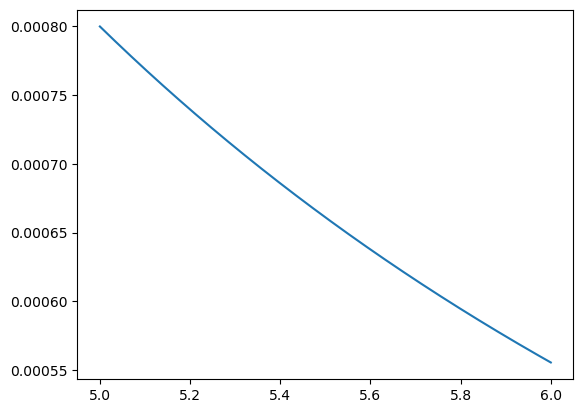

<Figure size 640x480 with 0 Axes>

In [57]:
plt.figure(1)
r0 = np.linspace(5,6,1000)
a0 = G*m[0,0]/(r0**2+rsoft**2)
plt.plot(r0,a0)

plt.figure(2)
#plt.hist(R,bins=100)
#plt.yticks(np.array([N*(N-1)/2]))